# LOPF with coupling to heating sector

In this example three locations are optimised, each with an electric bus and a heating bus and corresponding loads. At each location the electric and heating buses are connected with heat pumps; heat can also be supplied to the heat bus with a boiler. The electric buses are connected with transmission lines and there are electrical generators at two of the nodes.

In [13]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

#sns.set(rc={"figure.figsize": (9, 5)})

In [14]:
network = pypsa.Network()

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatib

Add three buses of AC and heat carrier each

In [15]:
for i in range(3):
    network.add("Bus", "electric bus {}".format(i), v_nom=20.0)
    network.add("Bus", "heat bus {}".format(i), carrier="heat")
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
electric bus 0,20.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,
heat bus 0,1.0,,0.0,0.0,heat,,1.0,0.0,inf,PQ,
electric bus 1,20.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,
heat bus 1,1.0,,0.0,0.0,heat,,1.0,0.0,inf,PQ,
electric bus 2,20.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,
heat bus 2,1.0,,0.0,0.0,heat,,1.0,0.0,inf,PQ,


In [16]:
network.buses["carrier"].value_counts()

carrier
AC      3
heat    3
Name: count, dtype: int64

Add three lines in a ring

In [17]:
for i in range(3):
    network.add(
        "Line",
        "line {}".format(i),
        bus0="electric bus {}".format(i),
        bus1="electric bus {}".format((i + 1) % 3),
        x=0.1,
        s_nom=1000,
    )
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
line 0,electric bus 0,electric bus 1,,0.1,0.0,0.0,0.0,1000.0,False,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 1,electric bus 1,electric bus 2,,0.1,0.0,0.0,0.0,1000.0,False,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 2,electric bus 2,electric bus 0,,0.1,0.0,0.0,0.0,1000.0,False,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Connect the electric to the heat buses with heat pumps with COP 3

In [18]:
for i in range(3):
    network.add(
        "Link",
        "heat pump {}".format(i),
        bus0="electric bus {}".format(i),
        bus1="heat bus {}".format(i),
        p_nom=100,
        efficiency=3.0,
    )
network.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
heat pump 0,electric bus 0,heat bus 0,,,3.0,0,inf,100.0,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump 1,electric bus 1,heat bus 1,,,3.0,0,inf,100.0,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump 2,electric bus 2,heat bus 2,,,3.0,0,inf,100.0,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


Add carriers

In [19]:
network.add("Carrier", "gas", co2_emissions=0.27)
network.add("Carrier", "biomass", co2_emissions=0.0)
network.carriers

attribute,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
gas,0.27,,,inf,0.0
biomass,0.00,,,inf,0.0


Add a gas generator at bus 0, a biomass generator at bus 1 and a boiler at all heat buses

In [20]:
network.add(
    "Generator",
    "gas generator",
    bus="electric bus 0",
    p_nom=100,
    marginal_cost=50,
    carrier="gas",
    efficiency=0.3,
)

network.add(
    "Generator",
    "biomass generator",
    bus="electric bus 1",
    p_nom=100,
    marginal_cost=100,
    efficiency=0.3,
    carrier="biomass",
)

for i in range(3):
    network.add(
        "Generator",
        "boiler {}".format(i),
        bus="heat bus {}".format(i),
        p_nom=1000,
        efficiency=0.9,
        marginal_cost=20.0,
        carrier="gas",
    )

network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
gas generator,electric bus 0,PQ,,100.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
biomass generator,electric bus 1,PQ,,100.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 0,heat bus 0,PQ,,1000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 1,heat bus 1,PQ,,1000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 2,heat bus 2,PQ,,1000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Add electric loads and heat loads.

In [21]:
for i in range(3):
    network.add(
        "Load",
        "electric load {}".format(i),
        bus="electric bus {}".format(i),
        p_set=i * 10,
    )

for i in range(3):
    network.add(
        "Load",
        "heat load {}".format(i),
        bus="heat bus {}".format(i),
        p_set=(3 - i) * 10,
    )

network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
electric load 0,electric bus 0,,,0.0,0.0,-1.0
electric load 1,electric bus 1,,,10.0,0.0,-1.0
electric load 2,electric bus 2,,,20.0,0.0,-1.0
heat load 0,heat bus 0,,,30.0,0.0,-1.0
heat load 1,heat bus 1,,,20.0,0.0,-1.0
heat load 2,heat bus 2,,,10.0,0.0,-1.0


We define a function for the LOPF

In [22]:
def run_lopf():
    network.optimize()
    df = pd.concat(
        [
            network.generators_t.p.loc["now"],
            network.links_t.p0.loc["now"],
            network.loads_t.p.loc["now"],
        ],
        keys=["Generators", "Links", "Line"],
        names=["Component", "index"],
    ).reset_index(name="Production")

    #sns.barplot(data=df, x="index", y="Production", hue="Component")
    plt.title(f"Objective: {network.objective}")
    plt.xticks(rotation=90)
    plt.tight_layout()

Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\scipy\sparse\_construct.py:148: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11 primals, 29 duals
Objective: 2.50e+03
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the con

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\par19744\AppData\Local\Temp\linopy-problem-s48894_p.lp --output
 C:\Users\par19744\AppData\Local\Temp\linopy-solve-m8preyqp.sol
Reading problem data from 'C:\Users\par19744\AppData\Local\Temp\linopy-problem-s48894_p.lp'...
29 rows, 11 columns, 42 non-zeros
150 lines were read
GLPK Simplex Optimizer 5.0
29 rows, 11 columns, 42 non-zeros
Preprocessing...
4 rows, 5 columns, 11 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.500e+01  ratio =  2.500e+01
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 4
      0: obj =   3.340000000e+04 inf =   7.020e+03 (3)
      4: obj =   2.700000000e+03 inf =   0.000e+00 (0)
*     7: obj =   2.500000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40436 bytes)

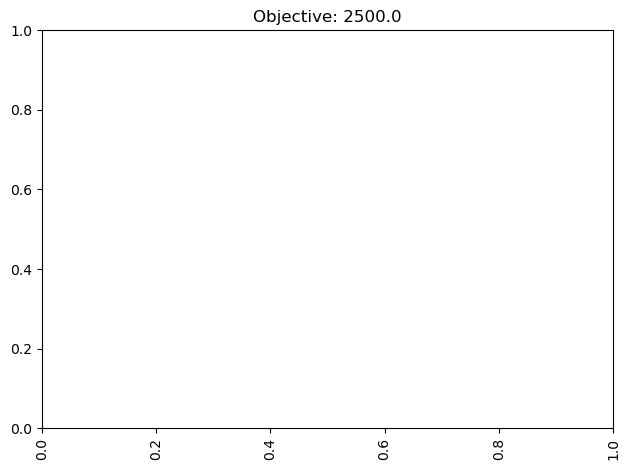

In [23]:
run_lopf()

Now, rerun with marginal costs for the heat pump operation.

Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\scipy\sparse\_construct.py:148: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11 primals, 29 duals
Objective: 2.70e+03
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the con

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\par19744\AppData\Local\Temp\linopy-problem-rlokhy24.lp --output
 C:\Users\par19744\AppData\Local\Temp\linopy-solve-mx10uu1j.sol
Reading problem data from 'C:\Users\par19744\AppData\Local\Temp\linopy-problem-rlokhy24.lp'...
29 rows, 11 columns, 42 non-zeros
153 lines were read
GLPK Simplex Optimizer 5.0
29 rows, 11 columns, 42 non-zeros
Preprocessing...
4 rows, 5 columns, 11 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.500e+01  ratio =  2.500e+01
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 4
      0: obj =   3.200000000e+03 inf =   7.020e+03 (3)
      4: obj =   2.700000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40436 bytes)
Writing basic solution to 'C:\Users\par19744\AppData\L

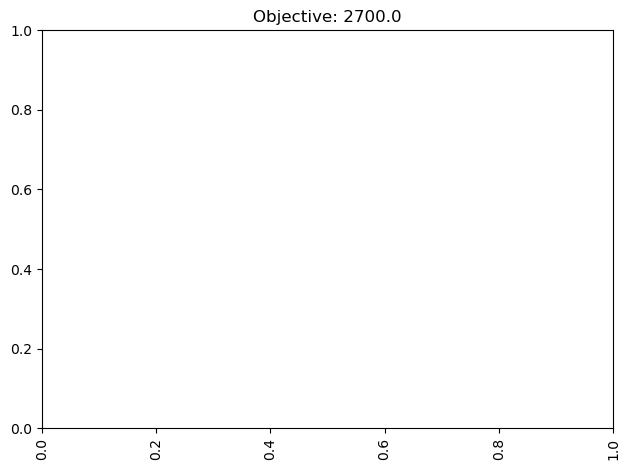

In [24]:
network.links.marginal_cost = 10
run_lopf()

Finally, rerun with no CO2 emissions.

Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='Line')
c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\par19744\.conda\envs\PyPSA\Lib\site-packages\scipy\sparse\_construct.py:148: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11 primals, 30 duals
Objective: 5.20e+03
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the con

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\par19744\AppData\Local\Temp\linopy-problem-l01tayb9.lp --output
 C:\Users\par19744\AppData\Local\Temp\linopy-solve-9ikc_yyf.sol
Reading problem data from 'C:\Users\par19744\AppData\Local\Temp\linopy-problem-l01tayb9.lp'...
30 rows, 11 columns, 46 non-zeros
159 lines were read
GLPK Simplex Optimizer 5.0
30 rows, 11 columns, 46 non-zeros
Preprocessing...
4 rows, 3 columns, 9 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.500e+01  ratio =  2.500e+01
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 3
      0: obj =   5.200000000e+03 inf =   2.997e+03 (2)
      2: obj =   5.200000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40436 bytes)
Writing basic solution to 'C:\Users\par19744\AppData\Lo

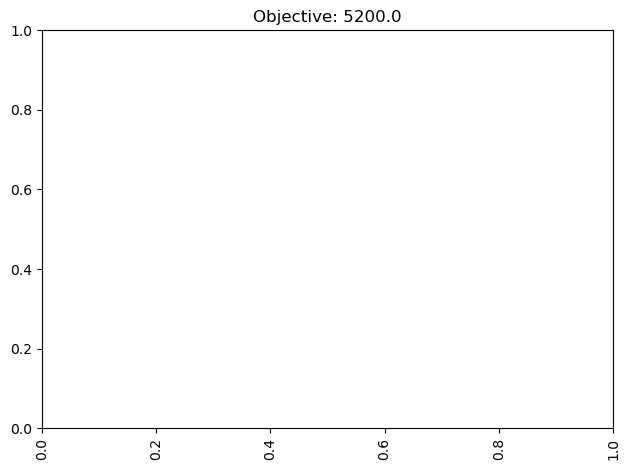

In [25]:
network.add("GlobalConstraint", "co2_limit", sense="<=", constant=0.0)

run_lopf()